In [1]:
#import all libraries

import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt

In [ ]:

dataset = tf.keras.preprocessing.image_dataset_from_directory(

    directory = "PlantVillage",
    batch_size=32,
    seed = 123,
    shuffle = True,
    image_size = [255,255]

)

Found 2152 files belonging to 3 classes.


In [12]:
classname = dataset.class_names

In [5]:
len(dataset)

68

In [8]:
import numpy as np
for batch_size,label_size in dataset.take(1):
    print("image size:", batch_size.shape)
    print("batch:", label_size.numpy)
    print("image",batch_size[0])

image size: (32, 255, 255, 3)
batch: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 2, 0, 0, 0, 0, 1, 1, 0], dtype=int32)>>
image tf.Tensor(
[[[162.90582  160.90582  171.90582 ]
  [128.81645  126.81645  137.81645 ]
  [108.07034  106.07034  117.07034 ]
  ...
  [163.0018   161.0018   175.0018  ]
  [158.04297  156.04297  170.04297 ]
  [153.03915  151.03915  165.03915 ]]

 [[148.61253  146.61253  157.61253 ]
  [ 98.383224  96.383224 107.38329 ]
  [144.12883  142.12883  153.1406  ]
  ...
  [158.95512  156.95512  170.95512 ]
  [164.95905  162.95905  176.95905 ]
  [167.97064  165.97064  179.97064 ]]

 [[100.59103   98.59103  109.610634]
  [117.39228  115.39228  126.42354 ]
  [186.45088  184.45088  197.45088 ]
  ...
  [162.981    160.981    174.981   ]
  [163.965    161.965    175.965   ]
  [163.94124  161.94124  175.94124 ]]

 ...

 [[141.92764  137.92764  152.92764 ]
  

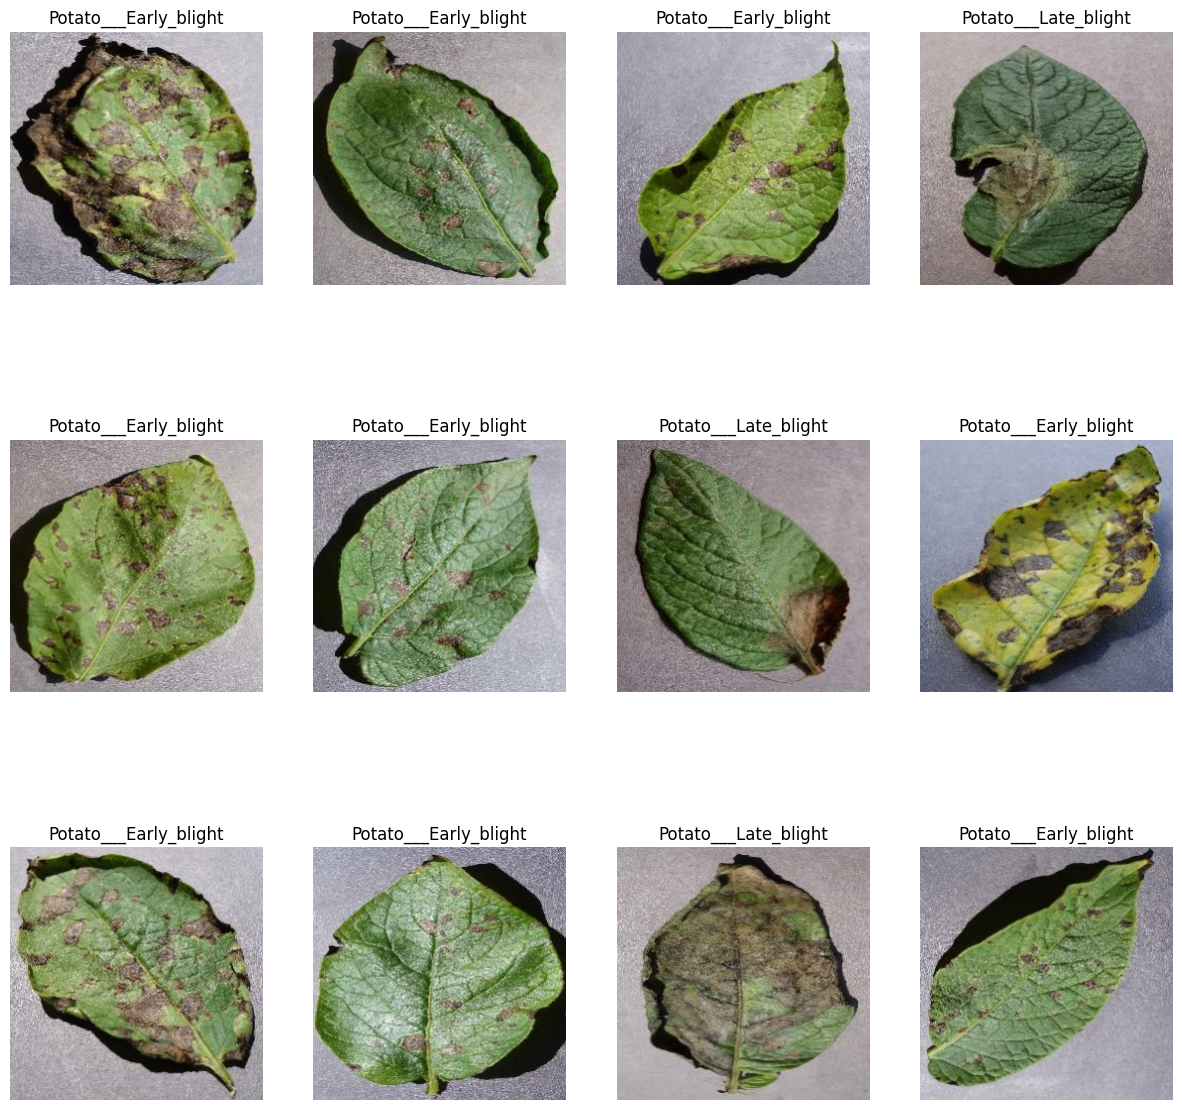

In [14]:
plt.figure(figsize=(15,15))
for image,label in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(classname[label[i]])
        plt.axis("off")

In [15]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [16]:
train_ds = dataset.take(54)

In [18]:
test_ds = dataset.skip(54)

In [19]:
len(test_ds)

14

In [20]:
val_size = 0.1
len(dataset)*val_size


6.800000000000001

In [26]:
val_ds = dataset.take(6)
test_ds = test_ds.skip(6)


In [22]:
len(train_ds)

54

In [23]:
len(test_ds)

8

In [27]:
len(val_ds)

6

In [30]:
def dataset_partion_tf(ds,train_split = 0.8, val_split = 0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split + test_split+val_split) == 1
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds,test_ds
train_ds,val_ds,test_ds = dataset_partion_tf(dataset)

    


In [31]:
len(train_ds)

54

In [32]:
len(test_ds)


8

In [33]:
len(val_ds)

6

In [34]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
